This capstone project addresses using proteomic data (protein and peptide data) from patients with Parkinson’s disease to predict the Unified Parkinson's Disease Rating Scale (MDS-UPDRS) score for patients for that visit and any potential future visits 6, 12 and 24 months later.
The data has been downloaded from a kaggle competition using the following url:
https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction/data.
The data sources are the following:
Training_dataset
train_peptides.csv-Mass spectrometry data at the peptide level
train_proteins.csv-Protein expression frequencies
Train_clinical_data.csv- Clinical information including patient ID, visit status, UPDRS score
Test dataset- Delivered through API
example_test_files-Data intended to illustrate how the API functions. .
Amp_pd_peptide- Files that enable the API. 
public_timeseries_testing_util.py An optional file intended to make it easier to run custom offline API tests. 



Import required libraries to enable the task



In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


Load the proteomic data files from the Parkinson's training dataset

In [8]:
Training_protein=pd.read_csv('training_data/train_proteins.csv')
Training_protein.head()



,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


You can see that each protein concentration is an NPX value, and the protein ID is UniProt.  

In [9]:
Training_protein.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232741 entries, 0 to 232740
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   visit_id     232741 non-null  object 
 1   visit_month  232741 non-null  int64  
 2   patient_id   232741 non-null  int64  
 3   UniProt      232741 non-null  object 
 4   NPX          232741 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 8.9+ MB


The info function tells us that there are no missing values for the training protein data.There are 232741 rows and 5 columns

In [10]:
Training_protein.describe()

,visit_month,patient_id,NPX
count,232741.000000,232741.000000,2.327410e+05
mean,26.099205,32593.881873,2.712077e+06
std,22.874719,18608.479506,2.224155e+07
min,0.000000,55.000000,8.460820e+01
25%,6.000000,16566.000000,2.946440e+04
50%,24.000000,29313.000000,1.135560e+05
75%,48.000000,49995.000000,5.638940e+05
max,108.000000,65043.000000,6.138510e+08


The visit_month values do not make sense, let us plot them as a hist distribution

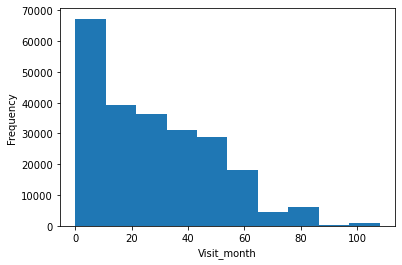

In [11]:
_=Training_protein["visit_month"].plot(kind="hist",bins=10)
_=plt.xlabel("Visit_month")
plt.show()

You can look at the values of the visit_month and see that they are whole range of values, we have to predict the UPDRS values for the patients at time point months, 6, 12 and 24 months later
Let us see for how many patient_IDs have 0, 6, 12 and 24 month values.

In [12]:
Training_protein.groupby("visit_month").size()






visit_month
0      40587
3        641
6      25991
12     37467
18      1657
24     36225
30       216
36     31156
48     28838
54       418
60     17572
72      4407
84      6288
96       423
108      855
dtype: int64

When we look at the frequency of the visit_month, we can see that the number of patients with protein data reduces fron 0, 6,12 and 24 months.

Next we will look at the distribution of the NPX values

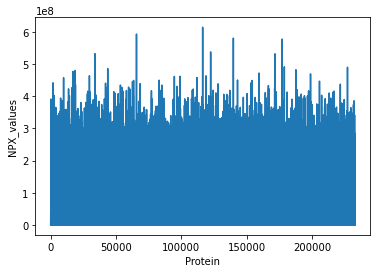

In [13]:
_=plt.plot(Training_protein['NPX'].values)
_=plt.xlabel("Protein")
_=plt.ylabel("NPX_values")
plt.show()

Given the distribution of the values, to make any comparisons we will be log2 normalising the data.

Look at how many patients have each of the protein ID:UniProt.

In [14]:
Training_protein.groupby("UniProt").size().sort_values()

UniProt
Q99829     489
Q99832     606
Q562R1     616
P01780     654
Q6UX71     661
          ... 
P02774    1113
P02787    1113
P02790    1113
Q12805    1113
P01042    1113
Length: 227, dtype: int64

In [ ]:
We can see that the no of proteins per patient varys.

Let us look at the training_peptide dataset now.

In [15]:
Training_peptide=pd.read_csv('training_data/train_peptides.csv')
Training_peptide.head()



,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


The training_peptide dataset has information on peptide and peptide abundance, the rest of the columns are the same as the protein column.

In [16]:
Training_peptide.describe()

,visit_month,patient_id,PeptideAbundance
count,981834.000000,981834.000000,9.818340e+05
mean,26.105061,32603.465361,6.428902e+05
std,22.913897,18605.934422,3.377989e+06
min,0.000000,55.000000,1.099850e+01
25%,6.000000,16566.000000,2.817425e+04
50%,24.000000,29313.000000,7.430830e+04
75%,48.000000,49995.000000,2.213388e+05
max,108.000000,65043.000000,1.787520e+08


In [11]:
Training_peptide.groupby("visit_month").size()

visit_month
0      171048
3        2742
6      110733
12     158114
18       6822
24     152036
30        913
36     130903
48     121343
54       1801
60      74562
72      18642
84      26729
96       1815
108      3631
dtype: int64

In [ ]:
We can see that peptide data varys for different months.

In [17]:
Training_peptide.groupby("UniProt").size().sort_values()

UniProt
Q99829      489
Q99832      606
Q562R1      616
P01780      654
Q6UX71      661
          ...  
P02649    23082
P02751    27370
P01024    35253
P02768    40900
P02787    51916
Length: 227, dtype: int64

The no of peptides per protein also varys in the dataset

In [18]:
Training_peptide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981834 entries, 0 to 981833
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   visit_id          981834 non-null  object 
 1   visit_month       981834 non-null  int64  
 2   patient_id        981834 non-null  int64  
 3   UniProt           981834 non-null  object 
 4   Peptide           981834 non-null  object 
 5   PeptideAbundance  981834 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 44.9+ MB


In [13]:
Training_peptide.dtypes

visit_id             object
visit_month           int64
patient_id            int64
UniProt              object
Peptide              object
PeptideAbundance    float64
dtype: object

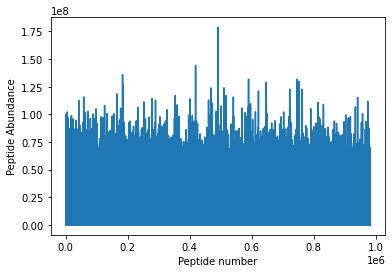

In [19]:
###Check how the peptide abundances look like
_=plt.plot(Training_peptide['PeptideAbundance'].values)
_=plt.xlabel("Peptide number")
_=plt.ylabel("Peptide Abundance")
plt.show()

Let us look at whether there are missing values in the protein and peptide datasets

In [24]:
Training_protein.isnull().sum()


visit_id       0
visit_month    0
patient_id     0
UniProt        0
NPX            0
dtype: int64

There are no missing values for protein in the training dataset.

In [20]:
Training_peptide.isnull().sum()


visit_id            0
visit_month         0
patient_id          0
UniProt             0
Peptide             0
PeptideAbundance    0
dtype: int64

No missing values for the peptide in training dataset.

Now we will be combining training_protein and training_peptide data for future use

In [21]:
Training_protein_peptide=  Training_peptide.merge(Training_protein,  on=['visit_id','visit_month','patient_id','UniProt'])



After doing a merge of the peptide and protein training datasets, let us look at how the dataset looks like

In [22]:
Training_protein_peptide.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,NPX
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0,732430.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0,732430.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,732430.0
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7,732430.0


We will now look at the clinical data for the training dataset.

In [23]:
Training_clinical=pd.read_csv('training_data/train_clinical_data.csv')
Training_clinical.head()
Training_clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             2615 non-null   object 
 1   patient_id                           2615 non-null   int64  
 2   visit_month                          2615 non-null   int64  
 3   updrs_1                              2614 non-null   float64
 4   updrs_2                              2613 non-null   float64
 5   updrs_3                              2590 non-null   float64
 6   updrs_4                              1577 non-null   float64
 7   upd23b_clinical_state_on_medication  1288 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 163.6+ KB


Let us have a look at the whether there are any missing values and what percentage of missing values there are for each attribute.

In [24]:
Training_clinical.isnull().sum()
missing = pd.concat([Training_clinical.isnull().sum(), 100 * Training_clinical.isnull().mean()], axis=1)

missing.columns=["count", "%"]
missing.sort_values(by=["count", "%"])

,count,%
visit_id,0,0.000000
patient_id,0,0.000000
visit_month,0,0.000000
updrs_1,1,0.038241
updrs_2,2,0.076482
updrs_3,25,0.956023
updrs_4,1038,39.694073
upd23b_clinical_state_on_medication,1327,50.745698


We know that there are missing values for our training clinical dataset. Very high percentage of missing values for updrs_4 and upd23b_clinical_state_on_medication, we are going to remove these two columns.

In [25]:

Training_clinical.drop(columns=["updrs_4","upd23b_clinical_state_on_medication"], inplace=True)

Let us look at the range of visit_months in the training clinical dataset

In [26]:

Training_clinical.groupby("visit_month").size()

visit_month
0      248
3      115
6      192
9       99
12     243
18     187
24     243
30     173
36     226
42     154
48     196
54     110
60     166
72      93
84     100
96      58
108     12
dtype: int64

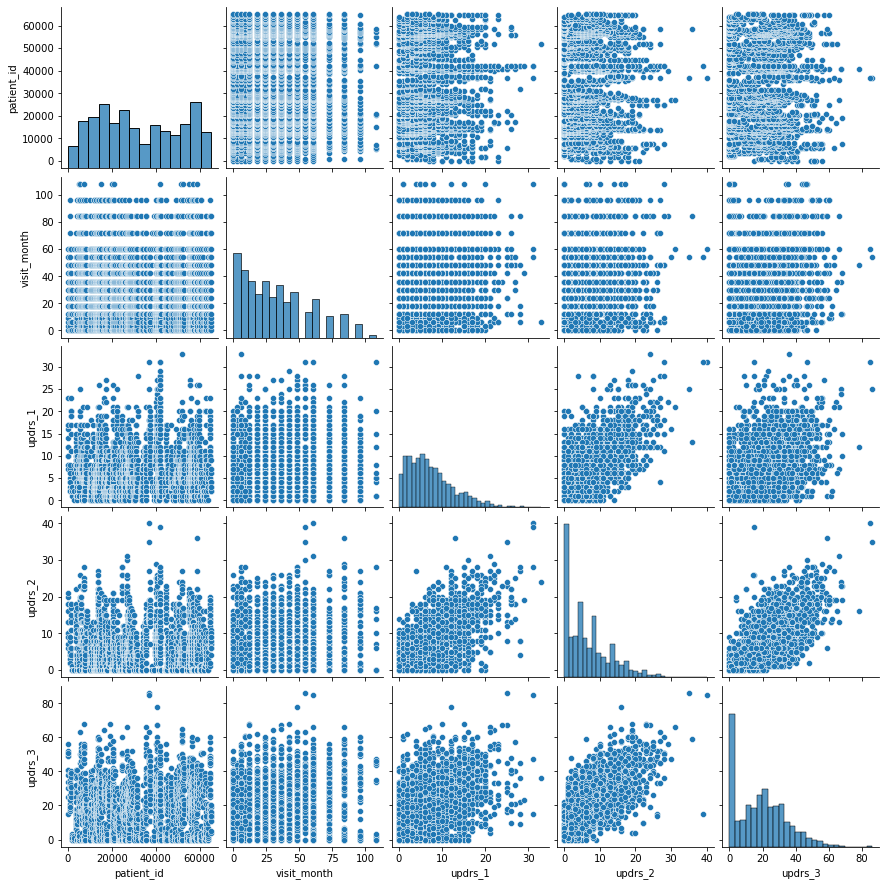

In [27]:
###Explore the relationship between the different UPDRS scores, are they correlated in anyway

_=sns.pairplot(Training_clinical, kind="scatter")
plt.show()


There is a correlation between the UPDRS scores. Let us look at the strength of the correlations.

In [28]:
#There seems to be a correlation between the UPDRS scores, let us look at correlations
Training_clinical.columns
Training_clinical[["updrs_1","updrs_2","updrs_3"]].corr()

,updrs_1,updrs_2,updrs_3
updrs_1,1.000000,0.661802,0.434569
updrs_2,0.661802,1.000000,0.735106
updrs_3,0.434569,0.735106,1.000000


Higher correlation between the updrs_2 and updrs_3 compared to with updrs_1

Let us look if the testing_datasets are in a similar format to the training_datasets

In [29]:
###Let us look if the testing_datasets are in a similar format to the training_datasets
Testing_protein=pd.read_csv('testing_data/example_test_files/test_proteins.csv')
Testing_protein.head()


,visit_id,visit_month,patient_id,UniProt,NPX,group_key
0,50423_0,0,50423,O00391,33127.90,0
1,50423_0,0,50423,O00533,490742.00,0
2,50423_0,0,50423,O00584,43615.30,0
3,50423_0,0,50423,O14773,16486.60,0
4,50423_0,0,50423,O14791,2882.42,0


In [30]:
Testing_peptide=pd.read_csv('testing_data/example_test_files/test_peptides.csv')
Testing_peptide.head()


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,group_key
0,50423_0,0,50423,O00391,AHFSPSNIILDFPAAGSAAR,22226.3,0
1,50423_0,0,50423,O00391,NEQEQPLGQWHLS,10901.6,0
2,50423_0,0,50423,O00533,GNPEPTFSWTK,51499.4,0
3,50423_0,0,50423,O00533,IEIPSSVQQVPTIIK,125492.0,0
4,50423_0,0,50423,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,23174.2,0


In [31]:
Testing_clinical=pd.read_csv('testing_data/example_test_files/test.csv')
Training_clinical.head()


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3
0,55_0,55,0,10.0,6.0,15.0
1,55_3,55,3,10.0,7.0,25.0
2,55_6,55,6,8.0,10.0,34.0
3,55_9,55,9,8.0,9.0,30.0
4,55_12,55,12,10.0,10.0,41.0


Yes the training and test datasets have similar formats. We will not combine the test protein and peptide datasets for now.

We will save cleaned files to be used for the EDA

In [34]:
Training_clinical.to_csv('Training_clinical_cleaned.csv',index=False)
Training_protein_peptide.to_csv("Protein_peptide_training.csv",index=False)


